# Análises COVID-19



In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from prophet import Prophet                                 # Dependendo da IDE talvez a bib se chame fbprophet


Importar os dados. É importante já dizer no comando `pd.read_csv` quais são as colunas que serão "parseadas" como datas. O pandas possui métodos robustos para trabalhar com esse tipo de informação.

In [8]:
# Url com o arquivo no repositório do curso pois até o momento não subi os Datasets para o GH
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'

df = pd.read_csv(url, parse_dates=['ObservationDate', 'Last Update'])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


Agora, conferindo os tipos das variáveis para verificar que as colunas foram corretamente importadas.

In [9]:
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

Nomes de colunas não devem ter letras maiúsculas e nem caracteres especiais. Vamos utilizar uma função para corrigir os nomes das colunas.

In [10]:
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [11]:
df.columns = [corrige_colunas(col) for col in df.columns]

In [12]:
df

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


## Análises

Começando a investigar as variáveis que tem-se à disposição. É sabido que trata-se de séries temporais que estão divididas por estado. Para fazer qualquer análise, portanto, precisamos dividir os nossos dados. 

Verificando primeiro quantos estados temos informações para o Brasil.

In [13]:
df.loc[df.countryregion == 'Brazil']

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
82,83,2020-01-23,NaN,Brazil,2020-01-23 17:00:00,0.0,0.0,0.0
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0


No caso do Brasil, não tem informação a nível de estado, apenas a nível do país. Então, verificando como está o comportamento dos casos confirmados no Brasil desde o primeiro caso confirmado, 26 de fevereiro.

## Casos confirmados

In [14]:
brasil = df.loc[(df.countryregion == 'Brazil') & (df.confirmed > 0)]

In [15]:
px.line?

Signature:
px.line(
    data_frame=None,
    x=None,
    y=None,
    line_group=None,
    color=None,
    line_dash=None,
    symbol=None,
    hover_name=None,
    hover_data=None,
    custom_data=None,
    text=None,
    facet_row=None,
    facet_col=None,
    facet_col_wrap=0,
    facet_row_spacing=None,
    facet_col_spacing=None,
    error_x=None,
    error_x_minus=None,
    error_y=None,
    error_y_minus=None,
    animation_frame=None,
    animation_group=None,
    category_orders=None,
    labels=None,
    orientation=None,
    color_discrete_sequence=None,
    color_discrete_map=None,
    line_dash_sequence=None,
    line_dash_map=None,
    symbol_sequence=None,
    symbol_map=None,
    markers=False,
    log_x=False,
    log_y=False,
    range_x=None,
    range_y=None,
    line_shape=None,
    render_mode='auto',
    title=None,
    template=None,
    width=None,
    height=None,
) -> plotly.graph_objs._figure.Figure
Docstring:
    In a 2D line plot, each row of `data_frame` i

In [16]:
px.line(brasil, 'observationdate', 'confirmed', 
        labels={'observationdate':'Data', 'confirmed':'Número de casos confirmados'},
       title='Casos confirmados no Brasil')

## Número de novos casos por dia

In [17]:
# Vamos implementar uma função para fazer a contagem de novos casos
brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0])
))

C:\Users\GeffDesk\AppData\Local\Temp\ipykernel_1712\2641012753.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
# Visualizando
px.line(brasil, x='observationdate', y='novoscasos', title='Novos casos por dia',
       labels={'observationdate': 'Data', 'novoscasos': 'Novos casos'})

## Mortes

In [20]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name='Mortes', mode='lines+markers',
              line=dict(color='red'))
)
#Edita o layout
fig.update_layout(title='Mortes por COVID-19 no Brasil',
                   xaxis_title='Data',
                   yaxis_title='Número de mortes')
fig.show()

# Taxa de crescimento

Calculando a taxa de crescimento do COVID desde o primeiro caso.

In [21]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [22]:
cresc_medio = taxa_crescimento(brasil, 'confirmed')
print(f"O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


Observandoo comportamento da **taxa de crescimento no tempo**. Para isso, será definida uma função para calcular a taxa de crescimento diária.

In [23]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)*100

In [24]:
tx_dia = taxa_crescimento_diaria(brasil, 'confirmed')

In [25]:
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [26]:
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()
px.line(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
        y=tx_dia, title='Taxa de crescimento de casos confirmados no Brasil',
       labels={'y':'Taxa de crescimento', 'x':'Data'})

# Predições

Construindo modelo de séries temporais para prever os novos casos. Antes será analisado a série temporal.

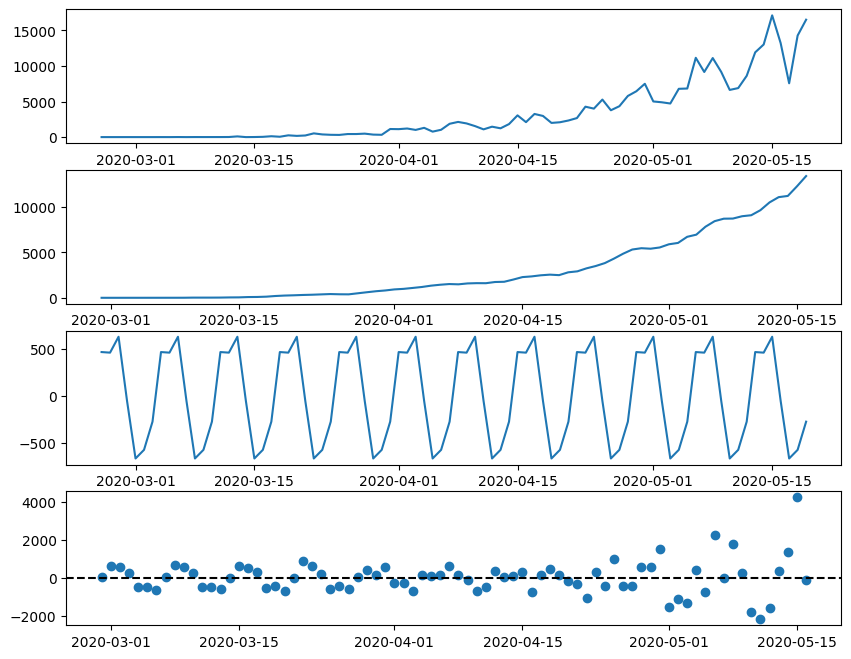

In [28]:
novoscasos = brasil.novoscasos
novoscasos.index = brasil.observationdate

res = seasonal_decompose(novoscasos)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

## Decompondo a série de confirmados



In [44]:
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate

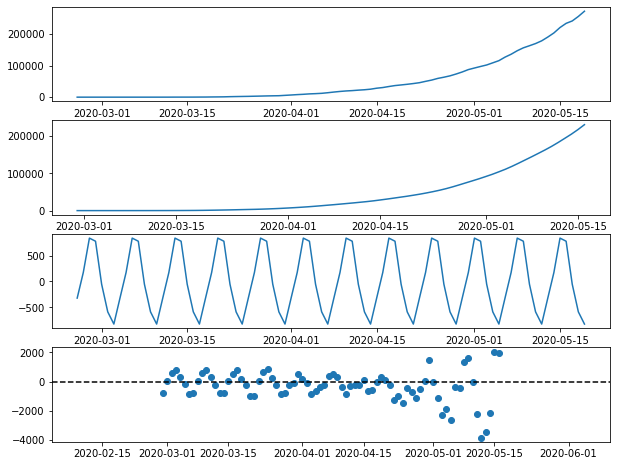

In [45]:
res2 = seasonal_decompose(confirmados)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res2.observed)
ax2.plot(res2.trend)
ax3.plot(res2.seasonal)
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

# Predizendo o número de casos confirmados com um AUTO-ARIMA

In [47]:
modelo = auto_arima(confirmados)

/home/neylson/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/neylson/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/neylson/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/neylson/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/neylson/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/neylson/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975

In [48]:
pd.date_range('2020-05-01', '2020-05-19')

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', freq='D')

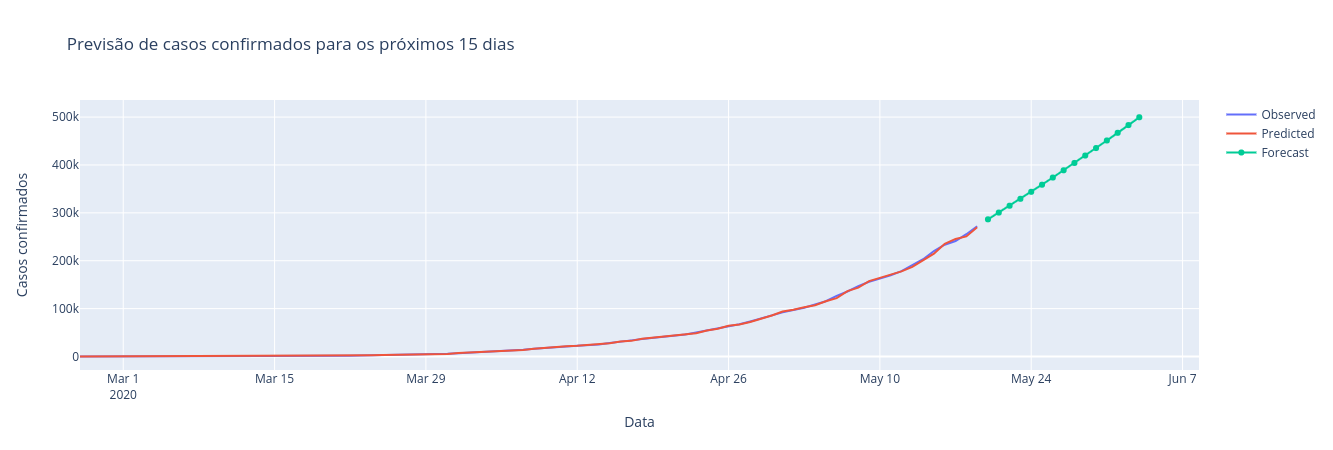

In [49]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observed'
))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

fig.add_trace(go.Scatter(x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados para os próximos 15 dias',
                 yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()

# Forecasting com Facebook Prophet

In [40]:
# Preparando os dados
train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

# Renomeia colunas
train.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

profeta = Prophet(growth="logistic", changepoints=['2020-03-21', '2020-03-30', '2020-04-25', '2020-05-03', '2020-05-10'])

#pop = 1000000  # Trocar esse dado para fazer outras predições
pop = 211463256 #https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php
train['cap'] = pop

# Treina o modelo
profeta.fit(train)

# Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast =  profeta.predict(future_dates)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


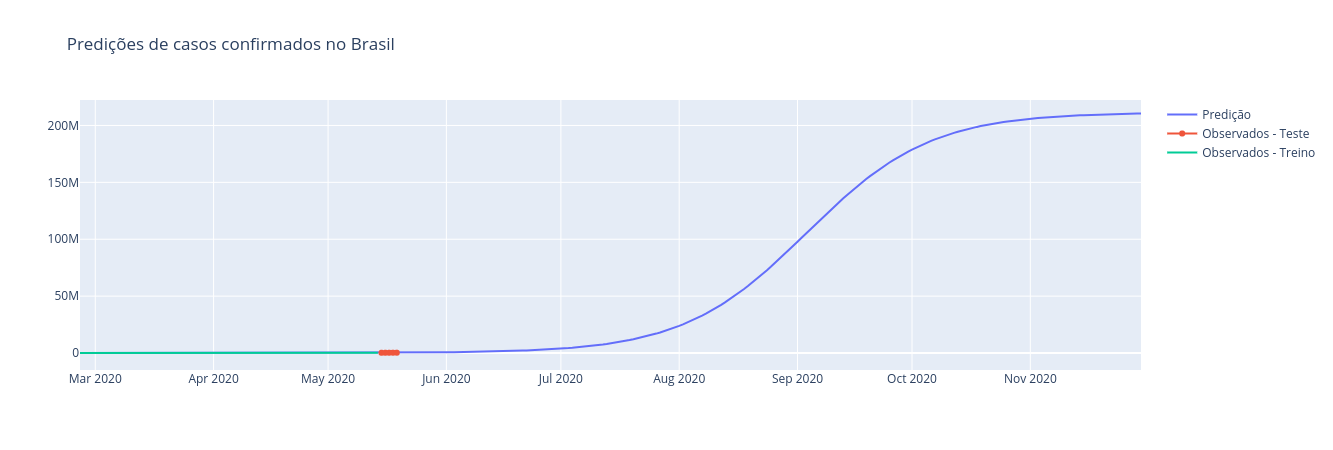

In [41]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(title='Predições de casos confirmados no Brasil')
fig.show()